# Compare various loss functions

This simulation was described in:

[Distance-IoU Loss: Faster and Better Learning for Bounding Box Regression](https://arxiv.org/pdf/1911.08287.pdf)




## Various imports

In [1]:
from typing import Final
from typing import Literal
from typing import Callable
from typing import Sequence
from typing import Optional
from typing import NamedTuple

import os
import math

from enum import Enum

from functools import partial

import numpy as np

import einops

import torch
import torch.func as tfn
import torchvision as tv

from tqdm.notebook import trange

import matplotlib.pyplot as plt


In [2]:
class BBCoordinates(NamedTuple):
    x1: torch.Tensor
    y1: torch.Tensor
    x2: torch.Tensor
    y2: torch.Tensor

    def get_width(self) -> torch.Tensor:
        return self.x2 - self.x1

    def get_height(self) -> torch.Tensor:
        return self.y2 - self.y1

    def get_area(self) -> torch.Tensor:
        return self.get_width() * self.get_height()

In [3]:
def l1_loss(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    reduction: Literal["none", "mean", "sum"] = "none",
) -> torch.Tensor:
    assert boxes1.size() == boxes2.size()
    loss = torch.abs(boxes1 - boxes2)

    if reduction == "sum":
        loss = loss.sum()
    elif reduction == "mean":
        loss = loss.mean()

    return loss


def smooth_l1_loss(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    beta: float = 1.0,
    reduction: Literal["none", "mean", "sum"] = "none",
) -> torch.Tensor:
    assert beta > 0
    assert boxes1.size() == boxes2.size()

    diff = torch.abs(boxes1 - boxes2)
    loss = torch.where(diff < beta, 0.5 * diff * diff / beta, diff - 0.5 * beta)

    if reduction == "sum":
        loss = loss.sum()
    elif reduction == "mean":
        loss = loss.mean()

    return loss

In [14]:
# All the functions in this cell are expecting
# bounding boxes in the format (x1, y1, x2, y2)

def intersection_area(
    boxes1: BBCoordinates,
    boxes2: BBCoordinates,
) -> torch.Tensor:
    x1, y1, x2, y2 = boxes1
    x1g, y1g, x2g, y2g = boxes2

    x1i = torch.max(x1, x1g)
    y1i = torch.max(y1, y1g)
    x2i = torch.min(x2, x2g)
    y2i = torch.min(y2, y2g)

    return (x2i - x1i).clamp(0) * (y2i - y1i).clamp(0)


def union_area(
    boxes1: BBCoordinates,
    boxes2: BBCoordinates,
    inter: torch.Tensor,
) -> torch.Tensor:
    return boxes1.get_area() + boxes2.get_area() - inter


def convex_width_height(
    boxes1: BBCoordinates,
    boxes2: BBCoordinates,
) -> tuple[torch.Tensor, torch.Tensor]:
    x1, y1, x2, y2 = boxes1
    x1g, y1g, x2g, y2g = boxes2

    cw = torch.max(x2, x2g) - torch.min(x1, x1g)  # convex width
    ch = torch.max(y2, y2g) - torch.min(y1, y1g)  # convex height

    return cw, ch


def compute_iou(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    eps: float = 1e-7,
) -> torch.Tensor:
    x1, y1, x2, y2 = boxes1.unbind(dim=-1)
    x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    b1_coords = BBCoordinates(x1, y1, x2, y2)
    b2_coords = BBCoordinates(x1g, y1g, x2g, y2g)

    inter = intersection_area(b1_coords, b2_coords)
    union = union_area(b1_coords, b2_coords, inter)

    iou = inter / (union + eps)

    return iou


def iou_loss(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    eps: float = 1e-7,
    reduction: Literal["none", "mean", "sum"] = "none",
) -> torch.Tensor:
    iou = compute_iou(boxes1, boxes2, eps=eps)

    loss = 1 - iou

    if reduction == "sum":
        loss = loss.sum()
    elif reduction == "mean":
        loss = loss.mean()

    return loss


def giou_loss(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    eps: float = 1e-7,
    reduction: Literal["none", "mean", "sum"] = "none",
) -> torch.Tensor:
    x1, y1, x2, y2 = boxes1.unbind(dim=-1)
    x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    b1_coords = BBCoordinates(x1, y1, x2, y2)
    b2_coords = BBCoordinates(x1g, y1g, x2g, y2g)

    inter = intersection_area(b1_coords, b2_coords)
    union = union_area(b1_coords, b2_coords, inter)

    iou = inter / (union + eps)

    S = 1 - iou

    # compute the penality term

    cw, ch = convex_width_height(b1_coords, b2_coords)

    convex_area = cw * ch

    penality = torch.abs(convex_area - union) / torch.abs(convex_area + eps)

    loss = S + penality

    if reduction == "sum":
        loss = loss.sum()
    elif reduction == "mean":
        loss = loss.mean()

    return loss


def diou_loss(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    eps: float = 1e-7,
    reduction: Literal["none", "mean", "sum"] = "none",
) -> torch.Tensor:
    x1, y1, x2, y2 = boxes1.unbind(dim=-1)
    x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    b1_coords = BBCoordinates(x1, y1, x2, y2)
    b2_coords = BBCoordinates(x1g, y1g, x2g, y2g)

    iou = compute_iou(boxes1, boxes2, eps=eps)

    cw, ch = convex_width_height(b1_coords, b2_coords)

    # convex diagonal squared
    diagonal_distance_squared = cw**2 + ch**2

    # compute center distance squared
    b1_x = (x1 + x2) / 2
    b1_y = (y1 + y2) / 2
    b2_x = (x1g + x2g) / 2
    b2_y = (y1g + y2g) / 2

    centers_distance_squared = (b1_x - b2_x) ** 2 + (b1_y - b2_y) ** 2

    S = 1 - iou
    D = centers_distance_squared / (diagonal_distance_squared + eps)

    loss = S + D

    if reduction == "sum":
        loss = loss.sum()
    elif reduction == "mean":
        loss = loss.mean()

    return loss


def ciou_loss(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    eps: float = 1e-7,
    reduction: Literal["none", "mean", "sum"] = "none",
) -> torch.Tensor:
    x1, y1, x2, y2 = boxes1.unbind(dim=-1)
    x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    b1_coords = BBCoordinates(x1, y1, x2, y2)
    b2_coords = BBCoordinates(x1g, y1g, x2g, y2g)

    iou = compute_iou(boxes1, boxes2, eps=eps)

    # part 1
    S = 1 - iou

    cw, ch = convex_width_height(b1_coords, b2_coords)

    # convex diagonal squared
    diagonal_distance_squared = cw**2 + ch**2

    # compute center distance squared
    b1_x = (x1 + x2) / 2
    b1_y = (y1 + y2) / 2
    b2_x = (x1g + x2g) / 2
    b2_y = (y1g + y2g) / 2

    centers_distance_squared = (b1_x - b2_x) ** 2 + (b1_y - b2_y) ** 2

    # part 2
    D = centers_distance_squared / (diagonal_distance_squared + eps)

    w1, h1 = b1_coords.get_width(), b1_coords.get_height()
    w2, h2 = b2_coords.get_width(), b2_coords.get_height()

    v = (4 / math.pi**2) * torch.pow(
        torch.atan(w2 / h2) - torch.atan(w1 / h1),
        2,
    )

    with torch.no_grad():
        alpha = v / ((1 - iou) + v)

    # part 3
    V = alpha * v

    loss = S + D + V

    if reduction == "sum":
        loss = loss.sum()
    elif reduction == "mean":
        loss = loss.mean()

    return loss

def siou_loss(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    eps: float = 1e-7,
    reduction: Literal["none", "mean", "sum"] = "none",
):
    """
    SIoU Loss https://arxiv.org/pdf/2205.12740.pdf
    """
    # x1, y1, x2, y2 = boxes1.unbind(dim=-1)
    # x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    b1_x1, b1_y1, b1_x2, b1_y2 = boxes1.unbind(dim=-1)
    b2_x1, b2_y1, b2_x2, b2_y2 = boxes2.unbind(dim=-1)

    b1_coords = BBCoordinates(b1_x1, b1_y1, b1_x2, b1_y2)
    b2_coords = BBCoordinates(b2_x1, b2_y1, b2_x2, b2_y2)

    iou = compute_iou(boxes1, boxes2, eps=eps)

    w1, h1 = b1_coords.get_width(), b1_coords.get_height()
    w2, h2 = b2_coords.get_width(), b2_coords.get_height()

    cw, ch = convex_width_height(b1_coords, b2_coords)

    s_cw = (b2_x1 + b2_x2 - b1_x1 - b1_x2) * 0.5 + eps
    s_ch = (b2_y1 + b2_y2 - b1_y1 - b1_y2) * 0.5 + eps
    sigma = torch.pow(s_cw**2 + s_ch**2, 0.5)
    sin_alpha_1 = torch.abs(s_cw) / sigma
    sin_alpha_2 = torch.abs(s_ch) / sigma
    threshold = pow(2, 0.5) / 2
    sin_alpha = torch.where(sin_alpha_1 > threshold, sin_alpha_2, sin_alpha_1)
    angle_cost = torch.cos(torch.arcsin(sin_alpha) * 2 - math.pi / 2)
    rho_x = (s_cw / cw) ** 2
    rho_y = (s_ch / ch) ** 2
    gamma = angle_cost - 2
    distance_cost = 2 - torch.exp(gamma * rho_x) - torch.exp(gamma * rho_y)
    omiga_w = torch.abs(w1 - w2) / torch.max(w1, w2)
    omiga_h = torch.abs(h1 - h2) / torch.max(h1, h2)
    shape_cost = torch.pow(1 - torch.exp(-1 * omiga_w), 4) + torch.pow(1 - torch.exp(-1 * omiga_h), 4)
    iou = iou - 0.5 * (distance_cost + shape_cost)

    loss = 1.0 - iou

    if reduction == "sum":
        loss = loss.sum()
    elif reduction == "mean":
        loss = loss.mean()

    return loss

    

## Setup simulated ground truth & anchor boxes

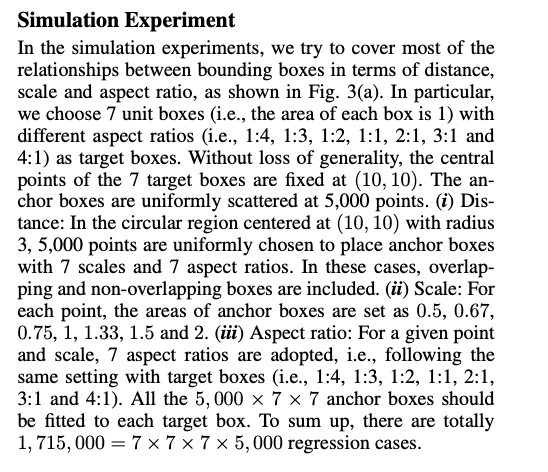

In [15]:
# The default aspect ratios and scales from the paper

DEFAULT_ASPECT_RATIOS: Final[tuple[float, ...]] = (
    1 / 4,
    1 / 3,
    1 / 2,
    1,
    2,
    3,
    4,
)
DEFAULT_ANCHOR_BOX_AREAS: Final[tuple[float, ...]] = (
    0.5,
    0.67,
    0.75,
    1.0,
    1.33,
    1.5,
    2.0,
)
DEFAULT_TARGET_BOX_AREAS: Final[tuple[float, ...]] = (1.0,)

DEFAULT_NUM_POINTS: Final[int] = 5000
DEFAULT_RADIUS: Final[int] = 3
DEFAULT_CENTER: Final[tuple[int, int]] = (10, 10)
DEFAULT_TARGET_CENTER: Final[tuple[int, int]] = (10, 10)

In [6]:
def bbox_to_matplotlib_rect(
    bbox: torch.Tensor,
    box_format: Literal["xyxy", "cxcywh"],
    color: str,
):
    """Convert bounding box to matplotlib format."""
    if box_format == "cxcywh":
        bbox = tv.ops.box_convert(bbox, "cxcywh", "xyxy")

    return plt.Rectangle(
        xy=(bbox[0], bbox[1]),
        width=bbox[2] - bbox[0],
        height=bbox[3] - bbox[1],
        fill=False,
        edgecolor=color,
        linewidth=2,
    )


def plot(
    *,
    target_boxes: torch.Tensor,
    anchor_boxes: torch.Tensor,
    box_format: Literal["xyxy", "cxcywh"],
    figsize=(5, 5),
    anchor_locations: Optional[torch.Tensor] = None,
    step_number: Optional[int] = None,
    point_color: str = "blue",
    anchor_box_color: str | Sequence[str] = "orange",
    target_box_color: str = "red",
):
    if isinstance(anchor_box_color, str):
        anchor_box_color = [anchor_box_color] * anchor_boxes.shape[0]

    if anchor_locations is not None:
        assert len(anchor_locations.shape) == 2

    assert len(target_boxes.shape) == 2

    assert target_boxes.shape[1] == 4
    assert anchor_boxes.shape[1] == 4

    figure, _ = plt.subplots(figsize=figsize)

    if step_number is not None:
        plt.title(f"Step {step_number}")

    if anchor_locations is not None:
        x = anchor_locations[:, 0]
        y = anchor_locations[:, 1]
        plt.scatter(x, y, edgecolors=point_color, marker="o", facecolors="none")

    # display the anchor boxes
    for idx in range(anchor_boxes.shape[0]):
        plt.scatter(
            anchor_boxes[idx][0],
            anchor_boxes[idx][1],
            marker="o",
            facecolors="none",
            edgecolors=anchor_box_color[idx],
        )
        rect = bbox_to_matplotlib_rect(anchor_boxes[idx], box_format, anchor_box_color[idx])
        figure.axes[0].add_patch(rect)

    # display the target boxes
    for idx in range(target_boxes.shape[0]):
        plt.scatter(
            target_boxes[idx][0],
            target_boxes[idx][1],
            marker="o",
            facecolors="none",
            edgecolors=target_box_color,
        )
        rect = bbox_to_matplotlib_rect(target_boxes[idx], box_format, target_box_color)
        figure.axes[0].add_patch(rect)

    plt.xlim(6.5, 14)
    plt.ylim(6.5, 14)
    plt.tight_layout()

In [16]:
class Simulator(object):
    def __init__(
        self,
        aspect_ratios: tuple[float, ...] = DEFAULT_ASPECT_RATIOS,
        anchor_box_areas: tuple[float, ...] = DEFAULT_ANCHOR_BOX_AREAS,
        target_box_areas: tuple[float, ...] = DEFAULT_TARGET_BOX_AREAS,
        num_points: int = DEFAULT_NUM_POINTS,
        radius: int = DEFAULT_RADIUS,
        c_xy: tuple[int,int] = DEFAULT_CENTER,
        seed: int = 2023,
    ):
        self.aspect_ratios = torch.Tensor(aspect_ratios)
        self.anchor_box_areas = torch.Tensor(anchor_box_areas)
        self.target_box_areas = torch.Tensor(target_box_areas)

        self.num_points = num_points
        self.radius = radius
        self.c_xy = c_xy
        self.seed = seed

        self.anchor_locations: torch.Tensor

    def get_target_boxes(
        self,
        c_xy: tuple[int,int] = DEFAULT_TARGET_CENTER,
    ) -> torch.Tensor:
        width = (self.target_box_areas[:, None] / self.aspect_ratios).sqrt()
        height = self.aspect_ratios * width

        target_wh = torch.stack([width, height], dim=-1)
        target_wh = einops.rearrange(target_wh, "n1 n2 wh -> (n1 n2) wh")

        target_xy = einops.repeat(
            torch.Tensor(c_xy),
            "xy -> n xy",
            n=target_wh.shape[0],
        )

        target_boxes = torch.hstack([target_xy, target_wh])
        return target_boxes

    def get_anchor_boxes(self) -> torch.Tensor:
        torch.manual_seed(self.seed)

        r = self.radius * torch.rand((self.num_points, 1))
        theta = 2 * np.pi * torch.rand((self.num_points, 1))
        x = self.c_xy[0] + r * torch.cos(theta)
        y = self.c_xy[1] + r * torch.sin(theta)

        self.anchor_locations = torch.hstack((x, y))

        width = (self.anchor_box_areas[:, None] / self.aspect_ratios).sqrt()
        height = self.aspect_ratios * width

        anchor_wh = torch.stack([width, height], dim=-1)
        anchor_wh = einops.rearrange(anchor_wh, "n1 n2 wh -> (n1 n2) wh")

        # repeat anchor boxes for every sample point
        anchor_wh = einops.repeat(
            anchor_wh,
            "n wh -> m n wh",
            m=self.anchor_locations.shape[0],
        )

        repeated_anchor_locations = einops.repeat(
            self.anchor_locations,
            "n xy -> n c xy",
            c=anchor_wh.shape[1],
        )

        return torch.concat([repeated_anchor_locations, anchor_wh], dim=-1)

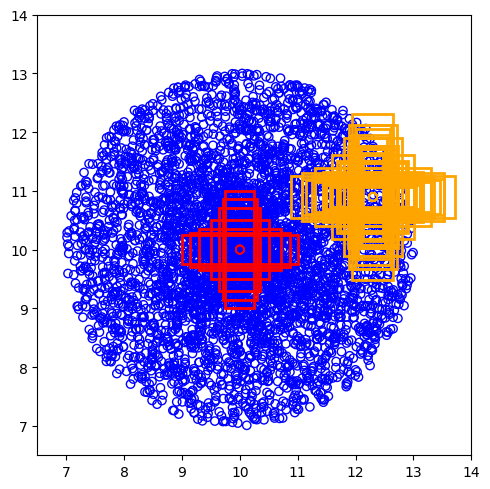

In [29]:
simulator = Simulator(seed=2045)
target_boxes = simulator.get_target_boxes()
anchor_boxes = simulator.get_anchor_boxes()

# displaying anchor boxes at a selected example point
EXAMPLE_SAMPLE_POINT = 180

plot(
    anchor_locations=simulator.anchor_locations,
    target_boxes=target_boxes,
    anchor_boxes=anchor_boxes[EXAMPLE_SAMPLE_POINT],
    box_format="cxcywh",
)

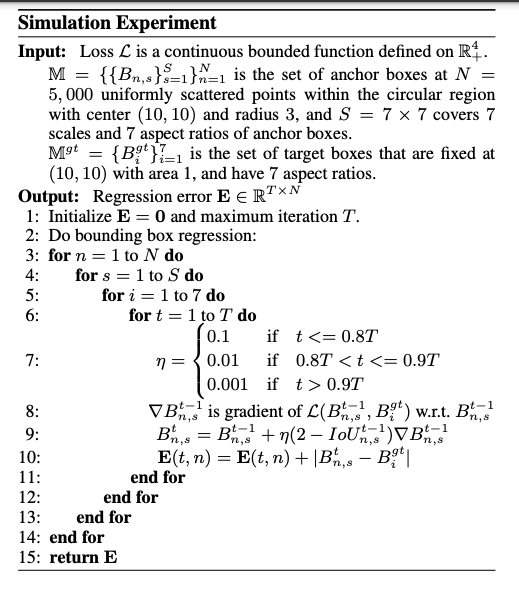

## Per sample gradients

In [30]:
# This function computes sample wise gradients
# using vmap and grad api from torch.func module

# Why is it needed?

# The gradient computation in pytorch requires that the loss
# is scalar. However, the experiement requires the gradients per
# sample.

# if you run naive loops like the one shown in the above algorithm
# and/or try the matlab code it would take many days to generate the results

# Below method efficiently computes the gradients per sample using the newly
# introduced vmap functionality in pytorch
#
# https://pytorch.org/tutorials/intermediate/per_sample_grads.html

def compute_gradients(
    anchor_boxes: torch.Tensor,
    target_boxes: torch.Tensor,
    loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
) -> torch.Tensor:

    def loss_one_sample(
        pred_sample: torch.Tensor,
        target_sample: torch.Tensor,
    ):

        # create a batch of 1
        pred_batch = pred_sample.unsqueeze(0)
        target_batch = target_sample.unsqueeze(0)

        loss = loss_fn(pred_batch, target_batch)
        # for L1/SmoothL1 etc it would be a tensor of 1,4
        # so we sum the loss over the last dimension
        loss = loss.sum(dim=-1)
        # make sure to remove the batch dimension
        loss = loss.squeeze()

        return loss

    ft_compute_grad = tfn.grad(loss_one_sample)
    ft_compute_sample_grad = tfn.vmap(ft_compute_grad, in_dims=(0, 0))

    anchor_gradients = ft_compute_sample_grad(anchor_boxes, target_boxes)
    return anchor_gradients

In [43]:
class ExperimentResult(NamedTuple):
    ious: list[float]
    errors: list[torch.Tensor]


class ExperimentRunner(object):
    def __init__(
        self,
        anchor_boxes: torch.Tensor,
        target_boxes: torch.Tensor,
        box_format: Literal["xyxy", "cxcywh"],
    ):
        # expected shapes
        # anchor_boxes - [num_points num_anchors 4]
        # target_boxes = [num_targets 4]

        # we need to align/repeat the anchor boxes and target boxes
        # so that every anchor box can be regressed against every
        # target box

        # note - order of first repeating anchor boxes and then target boxes is important
        anchor_boxes = einops.repeat(
            anchor_boxes,
            "num_points num_anchors coordinates -> num_points num_anchors r coordinates",
            r=target_boxes.shape[0],
        )

        target_boxes = einops.repeat(
            target_boxes,
            "num_targets coordinates -> n num_anchors num_targets coordinates",
            n=anchor_boxes.shape[0],
            num_anchors=anchor_boxes.shape[1],
        )

        assert anchor_boxes.shape == target_boxes.shape

        # let's flatten the anchor boxes and target boxes
        anchor_boxes = anchor_boxes.reshape(-1, 4)
        target_boxes = target_boxes.reshape(-1, 4)

        if box_format == "cxcywh":
            anchor_boxes = tv.ops.box_convert(
                anchor_boxes,
                in_fmt="cxcywh",
                out_fmt="xyxy",
            )
            target_boxes = tv.ops.box_convert(
                target_boxes,
                in_fmt="cxcywh",
                out_fmt="xyxy",
            )

        self.anchor_boxes = anchor_boxes
        self.target_boxes = target_boxes

    @staticmethod
    def get_eta(t: int, num_epochs: int) -> float:
        eta = 0.1
        if t > 0.8 * num_epochs and t <= 0.9 * num_epochs:
            eta = 0.01
        elif t > 0.9 * num_epochs:
            eta = 0.001
        return eta

    def step(
        self,
        pred_boxes: torch.Tensor,
        eta: torch.Tensor,
        loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    ) -> torch.Tensor:

        # compute the gradients
        gradients = compute_gradients(
            pred_boxes,
            self.target_boxes,
            loss_fn=loss_fn,
        )

        # adjust the gradients
        gradients = eta[:, None] * gradients

        # update the predicitons
        pred_boxes = pred_boxes - gradients

        return pred_boxes

    def get_error(self, pred_boxes: torch.Tensor) -> torch.Tensor:
        l1_error = l1_loss(pred_boxes, self.target_boxes, reduction="none")
        l1_error = l1_error.sum(dim=0)
        return l1_error

    def run(
        self,
        loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        num_epochs: int,
    ):
        pred_boxes = self.anchor_boxes.clone()

        errors: Sequence[torch.Tensor] = []
        ious: Sequence[float] = []

        for t in trange(num_epochs):
            # current IoU
            iou = compute_iou(pred_boxes, self.target_boxes)
            ious.append(iou.mean().item())

            # current error
            error = self.get_error(pred_boxes)
            errors.append(error)

            # compute the learning rate
            # See the algorithm above
            eta = (2 - iou) * ExperimentRunner.get_eta(t, num_epochs)

            # update the predictions using the gradients
            pred_boxes = self.step(pred_boxes, eta, loss_fn)

        return ExperimentResult(
            ious=ious,
            errors=errors,
        )

    def run_all(
        self,
        num_epochs: int,
    ) -> dict[str, ExperimentResult]:
        loss_fns_map = {
            # "l1": l1_loss,
            # "smooth_l1": smooth_l1_loss,
            "iou": iou_loss,
            "giou": giou_loss,
            "diou": diou_loss,
            "ciou": ciou_loss,
            "siou": siou_loss,
        }

        loss_fns_res: dict[str, ExperimentResult] = dict()

        for k, v in loss_fns_map.items():
            print(f"Running experiment for {k} loss ...")

            run_result = self.run(
                num_epochs=num_epochs,
                loss_fn=v,
            )

            loss_fns_res[k] = run_result

        return loss_fns_res

    @staticmethod
    def plot_error_curves(
        loss_fns_res: dict[str, ExperimentResult],
        specific_keys: Optional[Sequence[str]] = None,
    ):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        for k, v in loss_fns_res.items():
            if specific_keys is not None and k not in specific_keys:
                continue
            errors = torch.stack(v.errors)
            total_errors = errors.sum(dim=-1)
            axes[0].plot(range(len(v.ious)), total_errors, label=k)
            axes[1].plot(range(len(v.ious)), v.ious, label=k)

        axes[0].set_title("Total L1 Error")
        axes[0].set_xlabel("Epochs")
        axes[0].set_ylabel("L1 Error")
        axes[0].legend()

        axes[1].set_title("Mean IOU")
        axes[1].set_xlabel("Epochs")
        axes[1].set_ylabel("IoU")
        axes[1].legend()

        return fig, axes

Running experiment for iou loss ...


  0%|          | 0/200 [00:00<?, ?it/s]

Running experiment for giou loss ...


  0%|          | 0/200 [00:00<?, ?it/s]

Running experiment for diou loss ...


  0%|          | 0/200 [00:00<?, ?it/s]

Running experiment for ciou loss ...


  0%|          | 0/200 [00:00<?, ?it/s]

Running experiment for siou loss ...


  0%|          | 0/200 [00:00<?, ?it/s]

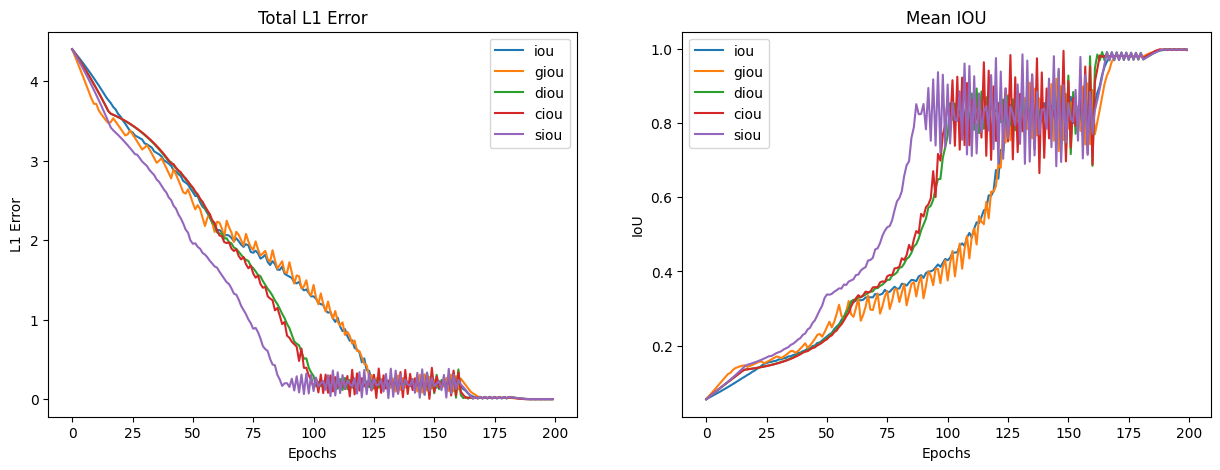

In [32]:
# Run experiment on a test box
# The example target and anchor box are taken from this script
# https://github.com/Zzh-tju/DIoU/blob/master/simulation%20experiment/simple_test.m

target_boxes = torch.tensor([10, 10, 1, 1]).unsqueeze(0)
anchor_boxes = torch.tensor([10.5, 11.6, 2.2, 3]).unsqueeze(0)

# we need to adjust anchor box to the shape required by runner
# which is 3 dimensional [num_points, num_anchors, coordinates]
anchor_boxes = anchor_boxes.unsqueeze(dim=1)

assert len(target_boxes.shape) == 2
assert len(anchor_boxes.shape) == 3

runner = ExperimentRunner(
    anchor_boxes=anchor_boxes,
    target_boxes=target_boxes,
    box_format="cxcywh",
)

loss_fns_res = runner.run_all(num_epochs=200)

fig, axes = ExperimentRunner.plot_error_curves(loss_fns_res)

fig;

## Attempt to reproduce the results from paper

Below image is from the paper -

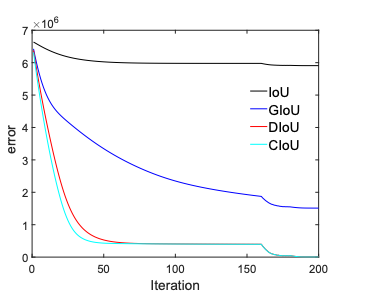

In [37]:
# Run experiment on the simulation data
# Attempt is to reproduce the results from
# https://github.com/Zzh-tju/DIoU/blob/master/simulation%20experiment/test_1715k.m
#
# and above image of various loss functions

# On my mac M1, every loss function run takes 24 seconds or less where as in
# google colab it takes minutes. Why Google Colab is so slow?

simulator = Simulator()
target_boxes = simulator.get_target_boxes()
anchor_boxes = simulator.get_anchor_boxes()

print("Target boxes - ")
print(target_boxes.shape)

print("Anchor boxes - ")
print(anchor_boxes.shape)

runner = ExperimentRunner(
    anchor_boxes=anchor_boxes,
    target_boxes=target_boxes,
    box_format="cxcywh",
)

loss_fns_res = runner.run_all(num_epochs=500)

Target boxes - 
torch.Size([7, 4])
Anchor boxes - 
torch.Size([5000, 49, 4])
Running experiment for iou loss ...


  0%|          | 0/500 [00:00<?, ?it/s]

Running experiment for giou loss ...


  0%|          | 0/500 [00:00<?, ?it/s]

Running experiment for diou loss ...


  0%|          | 0/500 [00:00<?, ?it/s]

Running experiment for ciou loss ...


  0%|          | 0/500 [00:00<?, ?it/s]

Running experiment for siou loss ...


  0%|          | 0/500 [00:00<?, ?it/s]

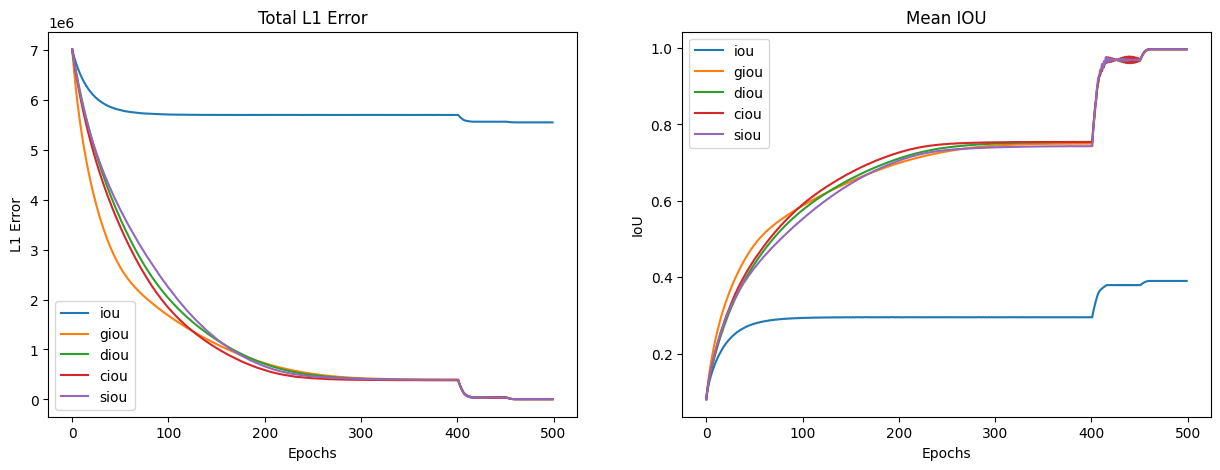

In [44]:
fig, axes = ExperimentRunner.plot_error_curves(loss_fns_res)

fig;